# **Домашнеее задание: Июльский курс (2020). Pro. Занятие 25**
## **Написание нейронных сетей с библиотекой PyTorch. Часть 1**
## Верхошинская Катерина Викторовна

## **LIGHT**

### **Задание:**

Используйте готовый ноутбук
1. Возьмите любые 10 изображений. Напишите свой класс для создания Dataset, в который на вход будут подаваться: путь с файлами, listID, labels. При этом изображения должны быть на выходе (xTrain) ч/б, перевернутые, урезанные до размера (32х32) и вытянутые в вектор.
2. Напишите архитектуру сетки, которая будет обрабатывать данные из пункта 1.
3. Напишите процесс обучения для такой архитектуры, используйте loss, criterion и optimizer не из занятия.


In [ ]:
 # Этим блоком будем визуализировать
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import scipy
 
# Библиотеки Pytorch
import torch 
import torchvision # здесь лежит mnist, cifar и много других датасетов и трансформаций для картинок
import torch.nn as nn # здесь лежат все слои
import torch.utils.data as data # работа с загрузчиком данных
import torchvision.transforms as transforms
import torchvision.datasets as dsets #работа с классом Датасет
from torch.autograd import Variable # для автоматического дифференциатора
 
# Визуализации графа
from torch.utils.tensorboard import SummaryWriter 
import datetime,os
import time
 
import seaborn as sns
import tensorflow.keras.preprocessing as tkp
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install Pillow

In [ ]:
# Используем готовый data loader от torch
path = '/content/drive/My Drive/Colab Notebooks/Базы/10 img/' 
listID = os.listdir(path)
labels = [0,1,2,3,4,5,6,7,8,9]
print(listID)

['avto.jpg', 'bird.jpg', 'cat.jpg', 'horse.jpg', 'man.jpg', 'moto.jpg', 'rosa.jpg', 'ship.jpg', 'woman.jpg', 'dog.jpg']


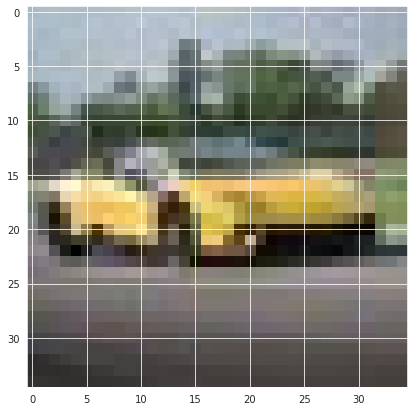

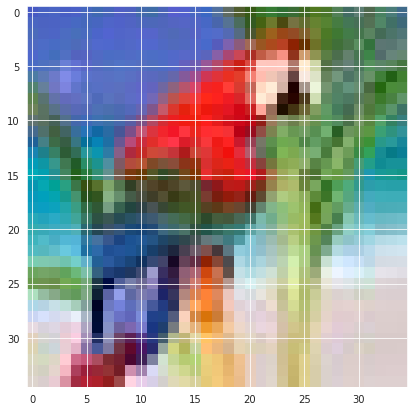

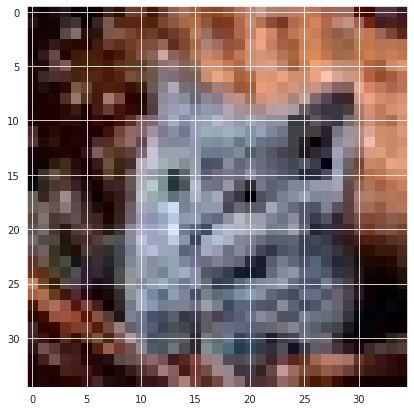

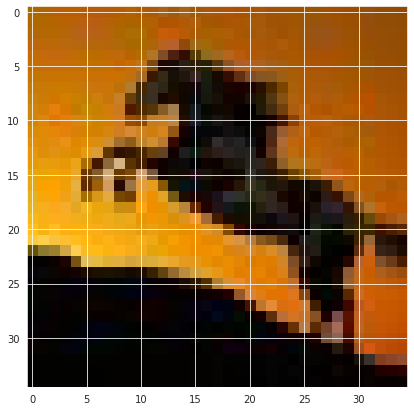

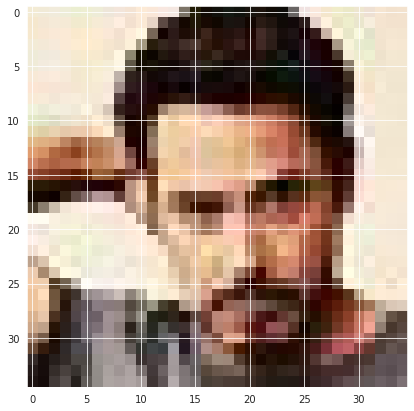

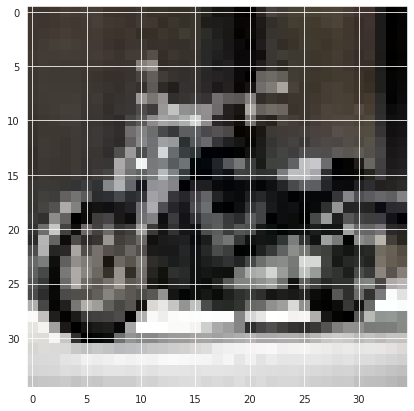

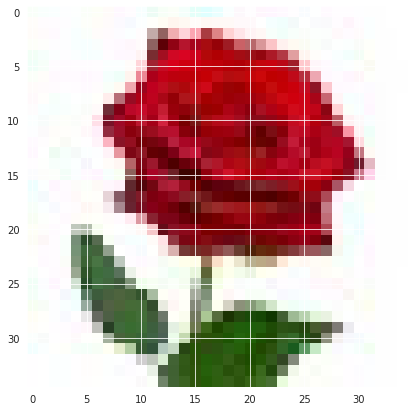

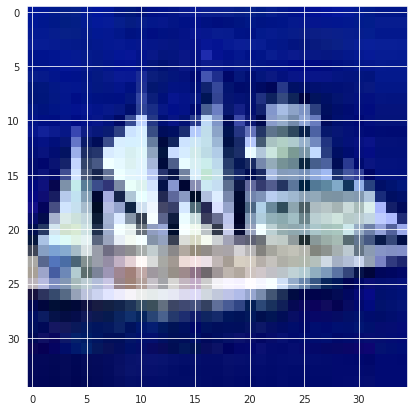

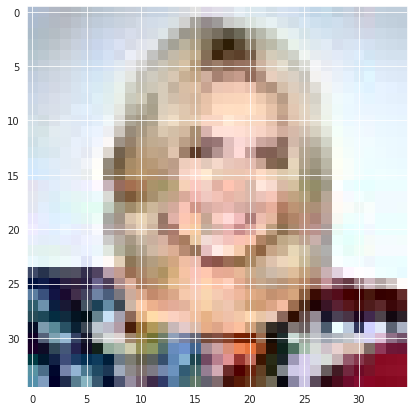

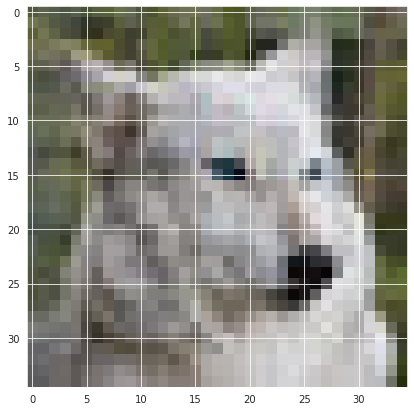

In [ ]:
for i in listID:
  plt.figure(figsize=(7,7))
  plt.imshow(Image.open(path+i))
  plt.show()

In [ ]:
# Создаем класс для собственных данных, наследуя свойства стандартного датасета
class CustomDataset(data.Dataset):
    def __init__(self, listID, labels, path, transforms = None): 
        # Инициализируем атрибуты (они абсолютно производные. У вас они могут быть совсем другими)
        self.listID = listID # listID список имен каждого экземпляра
        self.labels = labels # labels - то, что скормим как yTrain
        self.transforms = transforms # если нужны какие-то преобразования
        self.path = path # путь, где лежат данные
        

    def __getitem__(self, index):        
        # Открываем папку с данными (можно использовать numpy.fromfile, PIL.Image.open)
        ID = self.listID[index] # итерируем по каждому элементу в списке
        image = Image.open(path+ID) # извлекаем картинку по его ID

        image = self.transforms(image) # то, что лежит в transforms применяем к картинке
        array = tkp.image.img_to_array(image)
        # наша картинка уходит в xTrain для этой итерации
        xTrain = array.reshape(-1, 1024) # вытягиваем в вектор
        yTrain = self.labels[index] # лейбл для этой картинки уходит в yTrain

        # Возвращаем пару экзмепляр-метка
        #При этом изображения на выходе (xTrain) ч/б, перевернутые, урезанные до размера (32х32) и вытянутые в вектор
        return xTrain, yTrain

    def __len__(self):
        # Здесь общий размер вашего датасета
        return len(listID)

In [ ]:
# Пример последовательности трансфорирмирования для изображений
transform = transforms.Compose([
        transforms.Grayscale(), # ч/б
        transforms.RandomVerticalFlip(p=1.0), # перевернутые
        transforms.RandomResizedCrop((32,32)), # обрезание картинки до 32 на 32
        transforms.ToTensor()]) # преобразование в тензор

In [ ]:
customData = CustomDataset(listID,labels,path,transform)

In [ ]:
trainLoader = torch.utils.data.DataLoader(dataset=customData,
                                           batch_size=2, 
                                           shuffle=True,
                                           num_workers=4,)

In [ ]:
# Посмотрим на нашу выборку
dataIter = iter(trainLoader) # По какой выборке пройдемся
trainX, trainY = dataIter.next() # Присваиваем текущий batch

In [ ]:
trainX.shape

torch.Size([2, 1, 1024])

In [ ]:
trainX[1, 0].shape

torch.Size([1024])

Задаем параметры

In [ ]:
inputSize = 1024
numClasses = 10
numEpochs = 10
learningRate = 0.001 
hidden = 500

#### Архитектура сети



In [ ]:
# Создаем класс
class Classification(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__() # наследуе все свойства + добавляем свое
        self.layer1 = nn.Linear(inputSize, hidden_size) # первый слой - линейный
        self.relu = nn.ReLU() 
        self.layer2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1) # Поскольку задача классификации, то функция активации softmax

    def forward(self, x): # Здесь мы прописываем принципы, по которым данные будут проходить через сеть
        out = self.layer1(x)  # выход первого слоя
        out = self.relu(out) # применяем функцию активации к выходу первого слоя
        out = self.layer2(out) # передаем это во второй слой
        out = self.softmax(out) # применяем функцию активации ко второму слою
        return out

model = Classification(inputSize, hidden, numClasses) # Создаем объект нашей полносвязной сети

#### Функция ошибки и оптимизатор


In [ ]:
criterion = nn.NLLLoss() 
optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate)  # оптимизатор
losses = [] # сюда будет добавляться средняя ошибка. Список будем использовать для построения графика
model.train() # переход в режим обучения (опционально)

Classification(
  (layer1): Linear(in_features=1024, out_features=500, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=500, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

#### Обучаем модель




Эпоха: [1/10], Ошибка: 2.3658
Эпоха: [2/10], Ошибка: 2.2417
Эпоха: [3/10], Ошибка: 2.2687
Эпоха: [4/10], Ошибка: 2.3657
Эпоха: [5/10], Ошибка: 2.3472
Эпоха: [6/10], Ошибка: 2.2877
Эпоха: [7/10], Ошибка: 2.2516
Эпоха: [8/10], Ошибка: 2.4048
Эпоха: [9/10], Ошибка: 2.4519
Эпоха: [10/10], Ошибка: 2.3524


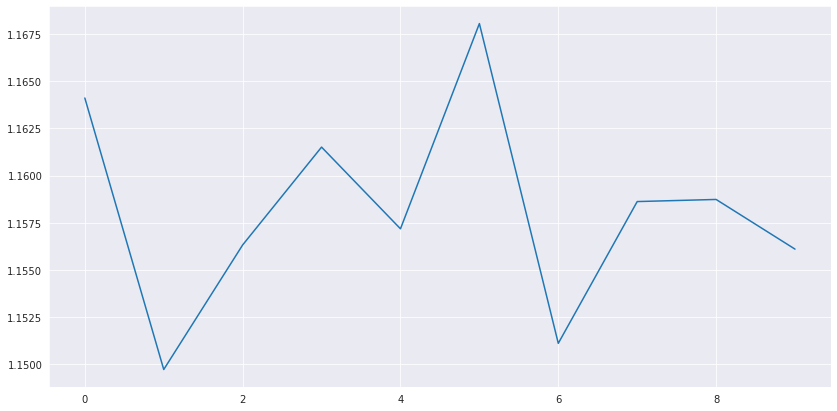

In [ ]:
for epoch in range(numEpochs): # количество эпох
    lossTot = 0 # потери в совокупности

    for i, (images, labels) in enumerate(trainLoader): # проходимся по всем данным в batch
        images = images.view(-1, 32*32) # приводим к правильному формату для сетки
        optimizer.zero_grad() # обнуляем градиент
        outputs = model(images) # здесь наше предсказание
        loss = criterion(outputs.log(), labels) # считаем ошибку 
        loss.backward()  # обратное распространение. 
                         # x.grad += dloss/dx для всех параметров x

        lossTot +=loss.detach().data # инкремент ошибки
        
        optimizer.step() # следующий шаг спуска

    losses.append(lossTot/10) # вычисляем среднюю ошибку и добавляем в список
    print('Эпоха: [%d/%d], Ошибка: %.4f' 
           % (epoch+1, numEpochs, loss))
plt.figure(figsize=(14,7))
plt.plot(losses) # График нашего обучения
plt.show()

**Итоги:**

Говорить о результатах обучения на 10 изображения трудно, но это и не было целью этого задания. Как и было поставлено в условие задачи, были взяты 10 изображений. Написан свой класс для создания Dataset, в который на вход подаються: путь с файлами, listID, labels. При этом изображения на выходе (xTrain) ч/б, перевернутые, урезанные до размера (32х32) и вытянутые в вектор.
Написана архитектура сетки, которая будет обрабатывать данные описанные выше.
Написан процесс обучения для такой архитектуры, с использованием loss, criterion и optimizer не из занятия.
